In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 3 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [3]:
df_raw[df_raw["tail_entity"].str.len() > 1].head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
1,test1,Who performed Loud Tour?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 398.40228271484375, 'min': 382.109619140625, 'std': 1.5429646156812833, 'mean': 383.59872814941406, 'median': 383.0782470703125}",{'Loud Tour': 398.40228271484375},"{'Loud Tour': 398.40228271484375, 'Tonnage Tour': 390.9110107421875, 'Pyromania World Tour': 390.05694580078125, 'Get Sleazy Tour': 389.4848937988281, 'Rocksimus Maximus Tour/World Domination Tour': 389.2545166015625, 'British Rock Symphony': 389.14709...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id': 4, 'type': 'PER', 'global_pos': [93, 93], 'index': '2_0'}, {'name': 'Rihanna', 'pos': [15, 16], 'sent_id': 2, 'type': 'PER', 'global_pos': [61, 61], 'index': '2_1'}, {'name': 'Rihanna', 'pos': [18, 19], 's...","{Loud, Loud Tour}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 0, 'type': 'MISC', 'global_pos': [1, 1], 

In [4]:
df = df_raw.copy()
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity"].str.len() >= 2]  # Another head in other sentence (2239 --> 420)
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
# df = df[df["tail_entity"].str.len() == 1]  # 1 Mention of the Tail in Doc
### Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if (l['h'] == label['h'] and l['t'] == label['t']):  # or (l['h'] == label['h'] and l['r'] == label['r'])
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
# df = df[df["repeated_label"]]
# df = df[df["head_entity"].str.len() == 2]  # 2 Head Entity (1 in evidence, 1 not in evidence)
print(len(df))  # 2239

def flatten(xss):
    return [x for xs in xss for x in xs]

def sentences_w_multiple_heads(head_enitites):
    sents = []
    repeated = []
    for e in head_enitites:
        sents.append(e["sent_id"])
        if sents.count(e["sent_id"]) > 1:
            repeated.append(e["sent_id"])
    return list(set(repeated))

def has_similar_label_to_tail(head_entity, row):
    for label in row["labels"]:
        if head_entity['sent_id'] in label['evidence'] and (label["r"] == row["label"]["r"] or label["t"] == row["label"]["t"] or label["h"] == row["label"]["t"]):
            return True
    return False

### Find Head in other sentences
head_w_tail_sents = []
head_wo_tail_sents = []
head_wo_tail_entity = []
for row in df.to_dict(orient="records"):
    head_w_tail = " ".join(flatten(row["evidence_sents"]))
    head_wo_tail = None
    sents_w_multiple_heads = sentences_w_multiple_heads(row["head_entity"])
    for head_entity in row["head_entity"]:
        evidence_sent_id = row["evidence_sent_ids"][0]
        if head_entity["sent_id"] != evidence_sent_id and head_entity["sent_id"] not in sents_w_multiple_heads:
            if not has_similar_label_to_tail(head_entity, row):
                head_wo_tail_ent = head_entity
                head_wo_tail = " ".join(row["sents"][head_entity["sent_id"]])
                break
    if head_wo_tail is None:
        head_w_tail_sents.append(None)
        head_wo_tail_sents.append(None)
        head_wo_tail_entity.append(None)
    else:
        head_w_tail_sents.append(head_w_tail)
        head_wo_tail_sents.append(head_wo_tail)
        head_wo_tail_entity.append(head_wo_tail_ent)
    
df["head_w_tail_sentence"] = head_w_tail_sents
df["head_wo_tail_sentence"] = head_wo_tail_sents
df["head_wo_tail_entity"] = head_wo_tail_entity
df = df.dropna(subset=["head_w_tail_sentence", "head_wo_tail_sentence"])
print(len(df))

### FILTER NOT SAME POS ENTITY {
# df["head_wo_tail_entity_pos"] = df["head_wo_tail_entity"].apply(lambda x: x["pos"][0])
# df["head_w_tail_entity_pos"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["pos"][0])
# df["head_pos_diff"] = df.apply(lambda r: np.abs(r["head_wo_tail_entity_pos"] - r["head_w_tail_entity_pos"]), axis=1)
# df = df[df["head_pos_diff"] < 10]
# print(len(df))
### }

### FILTER LEN DIFFERENT {
# df["sent_len_diff"] = df.apply(lambda r: np.abs(len(r["head_w_tail_sentence"].split()) - len(r["head_wo_tail_sentence"].split())), axis=1)
# df = df[df["sent_len_diff"] < 2]
# print(len(df))
### }

df = df.sample(250, random_state=0)
print(len(df))

sents_cols = []

# df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
# df["sents_complete_wo_beginning"] = df.apply(lambda r: r["head_wo_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
# sents_cols.append(f"sents_complete_w_beginning")
# sents_cols.append(f"sents_complete_wo_beginning")

df["sents_w_"] = df["head_w_tail_sentence"]
df["sents_wo_"] = df["head_wo_tail_sentence"]
sents_cols.append(f"sents_w_")
sents_cols.append(f"sents_wo_")

df[["query"] + sents_cols].sample(3)

420
316
250


,query,sents_w_,sents_wo_
3329,Which record label is My Red Hot Car associated with?,""" My Red Hot Car "" is a single by Squarepusher , released in 2001 on Warp Records .","An extended version of "" My Red Hot Car "" is featured on the album Go Plastic ."
133,Which country is Bear Valley Springs associated with?,"Bear Valley Springs is a guarded - gate community in Kern County , California , United States .",Bear Valley Springs is in the Tehachapi Mountains and is part of the greater Tehachapi area .
4214,When was Your Disco Needs You published?,""" Your Disco Needs You "" is a song performed by Australian recording artist and songwriter Kylie Minogue , taken from her seventh studio album Light Years ( 2000 ) .","Lyrically , "" Your Disco Needs You "" talks about the power of disco music ."


In [5]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [6]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,head_w_tail_sentence,head_wo_tail_sentence,head_wo_tail_entity,sents_w_,sents_wo_,facebook/dragon-plus-query-encoder_sents_w__dot,facebook/dragon-plus-query-encoder_sents_wo__dot,facebook/dragon-roberta-query-encoder_sents_w__dot,facebook/dragon-roberta-query-encoder_sents_wo__dot,facebook/contriever-msmarco_sents_w__dot,facebook/contriever-msmarco_sents_wo__dot,facebook/contriever_sents_w__dot,facebook/contriever_sents_wo__dot,OpenMatch/cocodr-base-msmarco_sents_w__dot,OpenMatch/cocodr-base-msmarco_sents_wo__dot,Shitao/RetroMAE_MSMARCO_finetune_sents_w__dot,Shitao/RetroMAE_MSMARCO_finetune_sents_wo__dot
3276,test15038,Who performed Demonstration?,[Demonstration (Tinie Tempah album)],"{'Demonstration (Tinie Tempah album)': {'text': 'Demonstration is the second studio album by British rapper Tinie Tempah . The album was released on 4 November 2013 as the follow - up to his commercially successful debut album , Disc - Overy ( 2010 ) ....","{'len': 1000, 'max': 398.9782409667969, 'min': 387.333251953125, 'std': 0.9361084748079989, 'mean': 388.2891842651367, 'median': 388.0381164550781}",{'Demonstration (Tinie Tempah album)': 398.9782409667969},"{'Demonstration (Tinie Tempah album)': 398.9782409667969, 'Queen live performances': 393.7038879394531, 'Ahmet Ertegun Tribute Concert': 392.1820983886719, 'Super Modern Artistic Performance': 391.8782958984375, 'Royal Command Performance': 391.6961364...","{'Demonstration (Tinie Tempah album)': {'text': 'Demonstration is the second studio album by British rapper Tinie Tempah . The album was released on 4 November 2013 as the follow - up to his commercially successful debut album , Disc - Overy ( 2010 ) ....",test15038,Demonstration (Tinie Tempah album),"[[{'type': 'MISC', 'pos': [0, 1], 'name': 'Demonstration', 'sent_id': 0, 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'Demonstration', 'pos': [0, 1], 'sent_id': 5, 'type': 'MISC', 'global_pos': [131, 131], 'index': '0_1'}], [{'name': 'British', 'pos...","[{'r': 'P577', 'h': 4, 't': 5, 'evidence': [1]}, {'r': 'P175', 'h': 4, 't': 2, 'evidence': [0, 1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0]}, {'r': 'P577', 'h': 7, 't': 3, 'evidence': [1, 3]}, {'r': 'P175', 'h': 7, 't': 2, 'evidence': [0, 3]}, {'...","[[Demonstration, is, the, second, studio, album, by, British, rapper, Tinie, Tempah, .], [The, album, was, released, on, 4, November, 2013, as, the, follow, -, up, to, his, commercially, successful, debut, album, ,, Disc, -, Overy, (, 2010, ), .], [In,...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0]}",2,"[{'type': 'MISC', 'pos': [0, 1], 'name': 'Demonstration', 'sent_id': 0, 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'Demonstration', 'pos': [0, 1], 'sent_id': 5, 'type': 'MISC', 'global_pos': [131, 131], 'index': '0_1'}]","[{'name': 'Tinie Tempah', 'pos': [9, 11], 'sent_id': 0, 'type': 'PER', 'global_pos': [9, 9], 'index':

['facebook/dragon-plus-query-encoder_sents_w__dot', 'facebook/dragon-plus-query-encoder_sents_wo__dot', 'facebook/dragon-roberta-query-encoder_sents_w__dot', 'facebook/dragon-roberta-query-encoder_sents_wo__dot', 'facebook/contriever-msmarco_sents_w__dot', 'facebook/contriever-msmarco_sents_wo__dot', 'facebook/contriever_sents_w__dot', 'facebook/contriever_sents_wo__dot', 'OpenMatch/cocodr-base-msmarco_sents_w__dot', 'OpenMatch/cocodr-base-msmarco_sents_wo__dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_w__dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_wo__dot']


  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low_stats,ttest_ci_high_stats,ttest_ci_low,ttest_ci_high,standard_ttest_ppf,mean_diff,std_diff,n
0,Contriever,facebook/contriever_sents_w__dot,facebook/contriever_sents_wo__dot,-10.942853,5.168610e-23,-0.120896,-0.084015,1.650996,1.650996,-1.650996,-0.102455,0.148038,250
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_w__dot,facebook/contriever-msmarco_sents_wo__dot,7.283307,4.275197e-12,0.061565,0.107203,1.650996,1.650996,-1.650996,0.084384,0.183190,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_w__dot,OpenMatch/cocodr-base-msmarco_sents_wo__dot,8.941154,8.921397e-17,1.043746,1.633478,1.650996,1.650996,-1.650996,1.338612,2.367179,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_w__dot,facebook/dragon-roberta-query-encoder_sents_wo__dot,12.558248,2.384158e-28,2.621408,3.596590,1.650996,1.650996,-1.650996,3.108999,3.914367,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_w__dot,Shitao/RetroMAE_MSMARCO_finetune_sents_wo__dot,12.843604,2.608333e-29,2.791407,3.802580,1.650996,1.650996,-1.650996,3.296993,4.058833,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_w__dot,facebook/dragon-plus-query-encoder_sents_wo__dot,13.535417,1.176481e-31,2.911136,3.902602,1.650996,1.650996,-1.650996,3.406869,3.979732,250


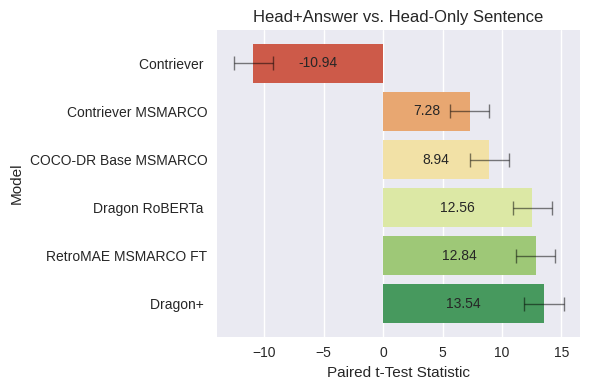

In [8]:
import pingouin as pg
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "_w_" in col1:
                ttest = stats.ttest_rel(df[col1], df[col2])
                ttest_pg = pg.ttest(df[col1], df[col2], paired=True, alternative='two-sided', correction='auto', r=0.707, confidence=0.95)
                # print(ttest)
                # print(ttest.confidence_interval(confidence_level=0.95))
                # print(ttest_pg)
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": ttest[0],
                    "ttest_pvalue": ttest[1],
                    "ttest_ci_low_stats": ttest.confidence_interval(confidence_level=0.95)[0],
                    "ttest_ci_high_stats": ttest.confidence_interval(confidence_level=0.95)[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "standard_ttest_ppf": standard_ttest_ppf(len(df)),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title(f"Head+Answer vs. Head-Only Sentence")
results_df.to_json("results/tail_df.json", orient="records")
ax = sns.barplot(
    data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig("figs/tail_ttest.pdf")
results_df

In [9]:
# Find Example
pd.set_option('display.max_colwidth', 400)
df = df_dot.copy()
df["diff"] = df["facebook/contriever_sents_w__dot"] - df["facebook/contriever_sents_wo__dot"]
df["diff"] = df["facebook/dragon-plus-query-encoder_sents_w__dot"] - df["facebook/dragon-plus-query-encoder_sents_wo__dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["evidence_len"].describe())
# df = df[df["evidence_len"] < 12]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff", "tail_entity"]].sort_values("diff", ascending=False)

count    250.000000
mean      26.124000
std       11.091289
min        9.000000
25%       18.000000
50%       24.000000
75%       31.000000
max       80.000000
Name: evidence_len, dtype: float64


,sents_w_,sents_wo_,title,query,evidence_text,gold_doc_len,diff,tail_entity
6121,"Fyns Hoved is a bight of northeastern Funen , Denmark , curving south to form the approach to Odense Fjord .","The eastern side of the bight between Fyns Hoved and Skoven , to the south , is irregular , with a beach and hills behind it , and to the south of the bight is a small , shallow bay , Korshavn Bay , with the Korshavn Light in the vicinity .",Fyns Hoved,Which country is Fyns Hoved associated with?,"Fyns Hoved is a bight of northeastern Funen , Denmark , curving south to form the approach to Odense Fjord .",282,13.604797,"[{'name': 'Denmark', 'pos': [9, 10], 'sent_id': 0, 'type': 'LOC', 'global_pos': [9, 9], 'index': '2_0'}]"
2879,"Hohenwald is a city in and the county seat of Lewis County , Tennessee .","David Sisco , who in 1974 placed ninth in points in the Winston Cup Series , is a native of Hohenwald , as was author William Gay , whose books include The Long Home , Provinces of Night , I Hate to See That Evening Sun Go Down , and Twilight .","Hohenwald, Tennessee",Which administrative territorial entity is Hohenwald located in?,"Hohenwald is a city in and the county seat of Lewis County , Tennessee .",252,12.728088,"[{'name': 'Lewis County', 'pos': [10, 12], 'sent_id': 0, 'type': 'LOC', 'global_pos': [10, 10], 'index': '1_0'}]"
6023,"Additionally , Amtrak operated a commuter service named the Chesapeake between 1978 – 1983 .",The Penn Line became the replacement for Amtrak 's Chesapeake as well as the minimal former PRR commuter service between Washington and Baltimore .,Penn Line,When was Chesapeake founded?,"Additionally , Amtrak operated a commuter service named the Chesapeake between 1978 – 1983 .",222,12.307281,"[{'type': 'TIME', 'pos': [11, 12], 'name': '1978', 'sent_id': 6, 'global_pos': [156, 156], 'index': '16_0'}]"
321,The ITS launch vehicle was a 2016 - 2017 design for a privately funded orbital launch vehicle planned to be developed by SpaceX.,"The second stage of the Earth launch vehicle was planned to have two versions , the Interplanetary spaceship for passengers and cargo and the ITS tanker to deliver propellants to Earth orbit .",ITS launch vehicle,Who manufactured ITS?,The ITS launch vehicle was a 2016 - 2017 design for a privately funded orbital launch vehicle planned to be developed by SpaceX.,477,11.597443,"[{'name': 'SpaceX.', 'pos': [22, 23], 'sent_id': 0, 'type': 'ORG', 'global_pos': [22, 22], 'index': '3_0'}]"
4246,"Breakout is an arcade game developed and published by Atari , Inc. , released on May 13 , 1976 .","In Breakout , a layer of bricks lines the top third of the screen .",Breakout (video game),Who is the publisher of Breakout?,"Breakout is an arcade game developed and published by Atari , Inc. , released on May 13 , 1976 .",217,11.553436,"[{'name': 'Atari, Inc.', 'pos': [9, 12], 'sent_id': 0, 'type': 'ORG', 'global_pos': [9, 9], 'index': '1_0'}, {'name': 'Atari', 'pos': [14, 15], 'sent_id': 1, 'type': 'ORG', 'global_pos': [34, 34], 'index': '1_1'}, {'type': 'ORG', 'pos': [9, 12], 'name': 'Atari , Inc.', 'sent_id': 0, 'global_pos': [9, 9], 'index': '1_2'}]"
...,...,...,...,...,...,...,...,...
1921,"Dare is the producer or devisor of various ( mainly comedy ) programmes mainly for BBC Radio and television , including The Mary Whitehouse Experience , Dead Ringers , The Now Show , The Late Edition , I 've Never Seen Star Wars and The Secret World , and Brian Gulliver 's Travels .","A running gag on the radio version of Dead Ringers was Jon Culshaw , in the style of Tom Baker saying Dare 's name in an exaggerated fashion at the end of the credits .",Bill Dare,What is the original network of Dead Ringers?,"Dare is the producer or devisor of various ( mainly comedy ) programmes mainly for BBC Radio and television , including The Mary Whitehouse Experience , Dead Ringers , The Now Show , The Late Edition , I 've Never Seen Star Wars and The Secret World , and Brian Gulliver 's Travels .",292,-6.262634,"[{'nam